<a href="https://colab.research.google.com/github/Sushmitha-Katti/EVA-4/blob/master/S12_V6(Reduce_increase_accuracy_45_)ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object classification on Tiny Imagenet Data

In [2]:
!pip install --no-cache-dir git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"
!git clone https://github.com/Sushmitha-Katti/PyTNet 
import sys
sys.path.append("PyTNet")

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-tocf3zqt
Albumentation library is successfully installed!
fatal: destination path 'PyTNet' already exists and is not an empty directory.


## **Importing Required files**

In [0]:
import torch
import train_test_loader
import show_images
import train_test
import evaluate
from Albumentationtransform import AlbumentationTransforms
from GradCam import GradCAM,visualize_cam
from LR_Range_Test import LR_test
from tinyimagenet import TinyImageNetDataSet

In [4]:
import albumentations as A
import cv2
channel_means = (0.4420803025777072,0.4420803025777072,0.4420803025777072)
channel_stdevs = (0.2782284187926345, 0.2782284187926345, 0.2782284187926345)
train_transform = AlbumentationTransforms([       
                                                                
                                      A.HorizontalFlip(p = 0.7),
                                      A.PadIfNeeded(min_height=70, min_width=70, border_mode=4, value=None, mask_value=None, always_apply=False, p=1.0),
                                      A.GaussNoise(var_limit=(10.0, 20.0), mean=0, always_apply=False, p=0.5),
                                      A.RandomCrop(64, 64, always_apply=False, p=1.0),
                                      A.RandomGamma(gamma_limit=(80, 120), eps=None, always_apply=False, p=0.5),
                                      A.VerticalFlip(always_apply=False, p=0.5),
                                      #A.Rotate(limit=50, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
                                    # A.Blur(blur_limit=5, always_apply=False, p=0.5),
                                      #A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.5),
                                      A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5),
                                     # A.GaussianBlur(blur_limit=7, always_apply=False, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=1, max_h_size=32,max_w_size = 32,p=0.7) 
                                       ])
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])
train_dataset , test_dataset,classes = TinyImageNetDataSet(train_split = 70,test_transforms = test_transform,train_transforms = train_transform)

Images already downloaded...


## **DataLoader**

In [0]:
trainloader, testloader = train_test_loader.load(train_dataset,test_dataset,batch_size=512)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


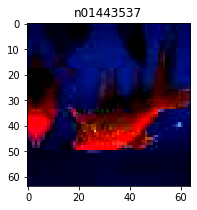

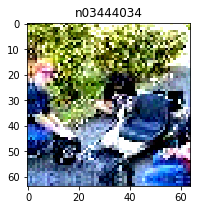

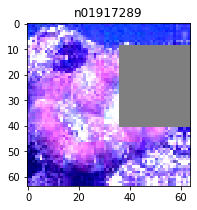

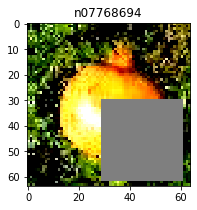

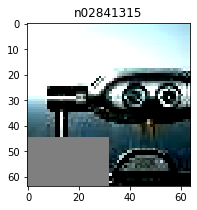

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision


# functions to show an image
def imshow(img,c ):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(3,3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)



def show_train_data(dataset, classes):

	# get some random training images

  dataiter = iter(dataset)
  images, labels = dataiter.next()
  for i in range(len(classes)):
    index = [j for j in range(5) if labels[j] == i]
    if(len(index) > 0):
      imshow(torchvision.utils.make_grid(images[index[0:5]],nrow=5,padding=2,scale_each=True),classes[i])
show_train_data(trainloader,classes)

## **Used Torchvisions resnet model, but not pre trained. Print the summary**

In [7]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)
summary(model, input_size=(3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

## **Initialise Optimiser,Scheduler, Criterion**

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR

optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay = 0.0001,nesterov = True ) 
criterion = nn.CrossEntropyLoss()
scheduler = OneCycleLR(optimizer, max_lr = 0.2, total_steps=None, epochs=30, steps_per_epoch=1, pct_start=1/3, anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =10)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr = 0.002, max_lr= 0.02, step_size_up=5, step_size_down=None, mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=False, base_momentum=0.8, max_momentum=0.9, last_epoch=-1)

## **Train Model**

In [0]:

train_test.train_model(model,device,trainloader,testloader,optimizer,criterion,30,scheduler,batch_scheduler=False,best_acc = 0,path = "newtinymodel.pt")

EPOCH: 1 LR: 0.02




Test set: Average loss: 0.0091, Accuracy: 2171/33000 (6.58%)

accuracy increased, Saving model....
EPOCH: 2 LR: 0.04




Test set: Average loss: 0.0080, Accuracy: 4298/33000 (13.02%)

accuracy increased, Saving model....
EPOCH: 3 LR: 0.06




Test set: Average loss: 0.0076, Accuracy: 5004/33000 (15.16%)

accuracy increased, Saving model....
EPOCH: 4 LR: 0.08




Test set: Average loss: 0.0074, Accuracy: 5760/33000 (17.45%)

accuracy increased, Saving model....
EPOCH: 5 LR: 0.1




Test set: Average loss: 0.0071, Accuracy: 6549/33000 (19.85%)

accuracy increased, Saving model....
EPOCH: 6 LR: 0.12000000000000002




Test set: Average loss: 0.0071, Accuracy: 6737/33000 (20.42%)

accuracy increased, Saving model....
EPOCH: 7 LR: 0.14




Test set: Average loss: 0.0069, Accuracy: 7522/33000 (22.79%)

accuracy increased, Saving model....
EPOCH: 8 LR: 0.16




Test set: Average loss: 0.0070, Accuracy: 7095/33000 (21.50%)

EPOCH: 9 LR: 0.18




Test set: Average loss: 0.0066, Accuracy: 8253/33000 (25.01%)

accuracy increased, Saving model....
EPOCH: 10 LR: 0.2


In [0]:
model = torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay = 0.0001,nesterov = True ) 
checkpoint = torch.load("tinymodel3.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()
print("Loaded the best model")

In [0]:
optimizer.param_groups[0]['lr'] = 0.002

In [0]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=False, threshold=0.0001, threshold_mode='abs', cooldown=0, min_lr=1e-4, eps=1e-4)
train_test.train_model(model,device,trainloader,testloader,optimizer,criterion,20,scheduler,batch_scheduler=False,best_acc = 41.68,path = "tinymodel2.pt")